In [1]:
# YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.ticker import MaxNLocator
import re
%matplotlib inline


import random
import importlib
import Scripts.autoencoder as ae
import Scripts.wake_processing as wp
from scipy.stats import wasserstein_distance as w_dist

In [2]:
importlib.reload(ae)
importlib.reload(wp)

<module 'Scripts.wake_processing' from 'E:\\Studies\\Deep Water\\DeepWater\\Scripts\\wake_processing.py'>

## Reading data

In [3]:
data_series = wp.get_files()

In [4]:
## Fixing shifted wake time stamps in data
# Special cases - no data - ignored
# ws:  2094960
# ws:  2418060
wake_start = wp.get_wakes()
new_ws = wake_start
for ws in wake_start:
    if ws not in set(data_series[0,-2,:]):
        if ws-12 in set(data_series[0,-2,:]):
            new_ws = np.append(new_ws, ws-12)

## Train/test split

In [5]:
# 22 to 25 September for the test set.
cutoff = np.where(data_series[0,-2]<wp.date_to_stamp([9, 22, 0, 0]))[0][-1]
train_data_series = data_series[:,:-1,:cutoff]
test_data_series = data_series[:,:-1,cutoff:]
train_dn_series = data_series[:,:,:cutoff]
test_dn_series = data_series[:,:,cutoff:]

In [6]:
train_data_series.shape

(4, 29, 69182)

In [7]:
wake_samples = wp.frames_by_timestamps(train_data_series, new_ws)

In [8]:
wake_samples.shape

(142, 4, 29, 60)

In [9]:
wake_samples.min()

0.028031500056385994

In [12]:
#np.save('Data\\Wake data\\confirmed_wakes', wake_samples) 

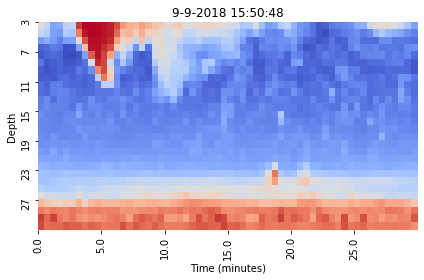

In [11]:
#wp.make_heatmap(wake_samples[141,3,:-1,:], wake_samples[141,3,-1,:], save = True, filename = "Wake Figures/wake_sample.png")
wp.make_heatmap(wake_samples[141,3,:-1,:], wake_samples[141,3,-1,:])

In [104]:
tiny_real = []
for i in [5, 7, 12, 24, 28]:
    tiny_real.append(wake_samples[i,:,:-1,:])
tiny_real = np.array(tiny_real)

In [52]:
#np.save('Data\\Wake data\\clean_positive_samples', tiny_real)

## Clean negative samples

In [17]:
negative_clean_data = pd.read_csv('negative examples.csv', sep = ';')
negative_clean_samples = negative_clean_data[negative_clean_data.columns[1]]

In [18]:
negative_clean_dates = []
for line in negative_clean_samples:
    l = line.split('.')
    l1 = l[2].split(' ')
    l2 = l1[1].split(':')
    timestamp = []
    timestamp.append(int(l[1]))
    timestamp.append(int(l[0]))
    timestamp.append(int(l2[0]))
    timestamp.append(0)
    negative_clean_dates.append(timestamp)

In [19]:
negative_clean_timestamps = []
for ts in negative_clean_dates:
    negative_clean_timestamps.append(wp.date_to_stamp(ts))

In [20]:
clean_neg_frames = wp.frames_by_timestamps(train_data_series, negative_clean_timestamps)

In [51]:
#np.save('Data\\Wake data\\clean_negative_samples', clean_neg_frames)

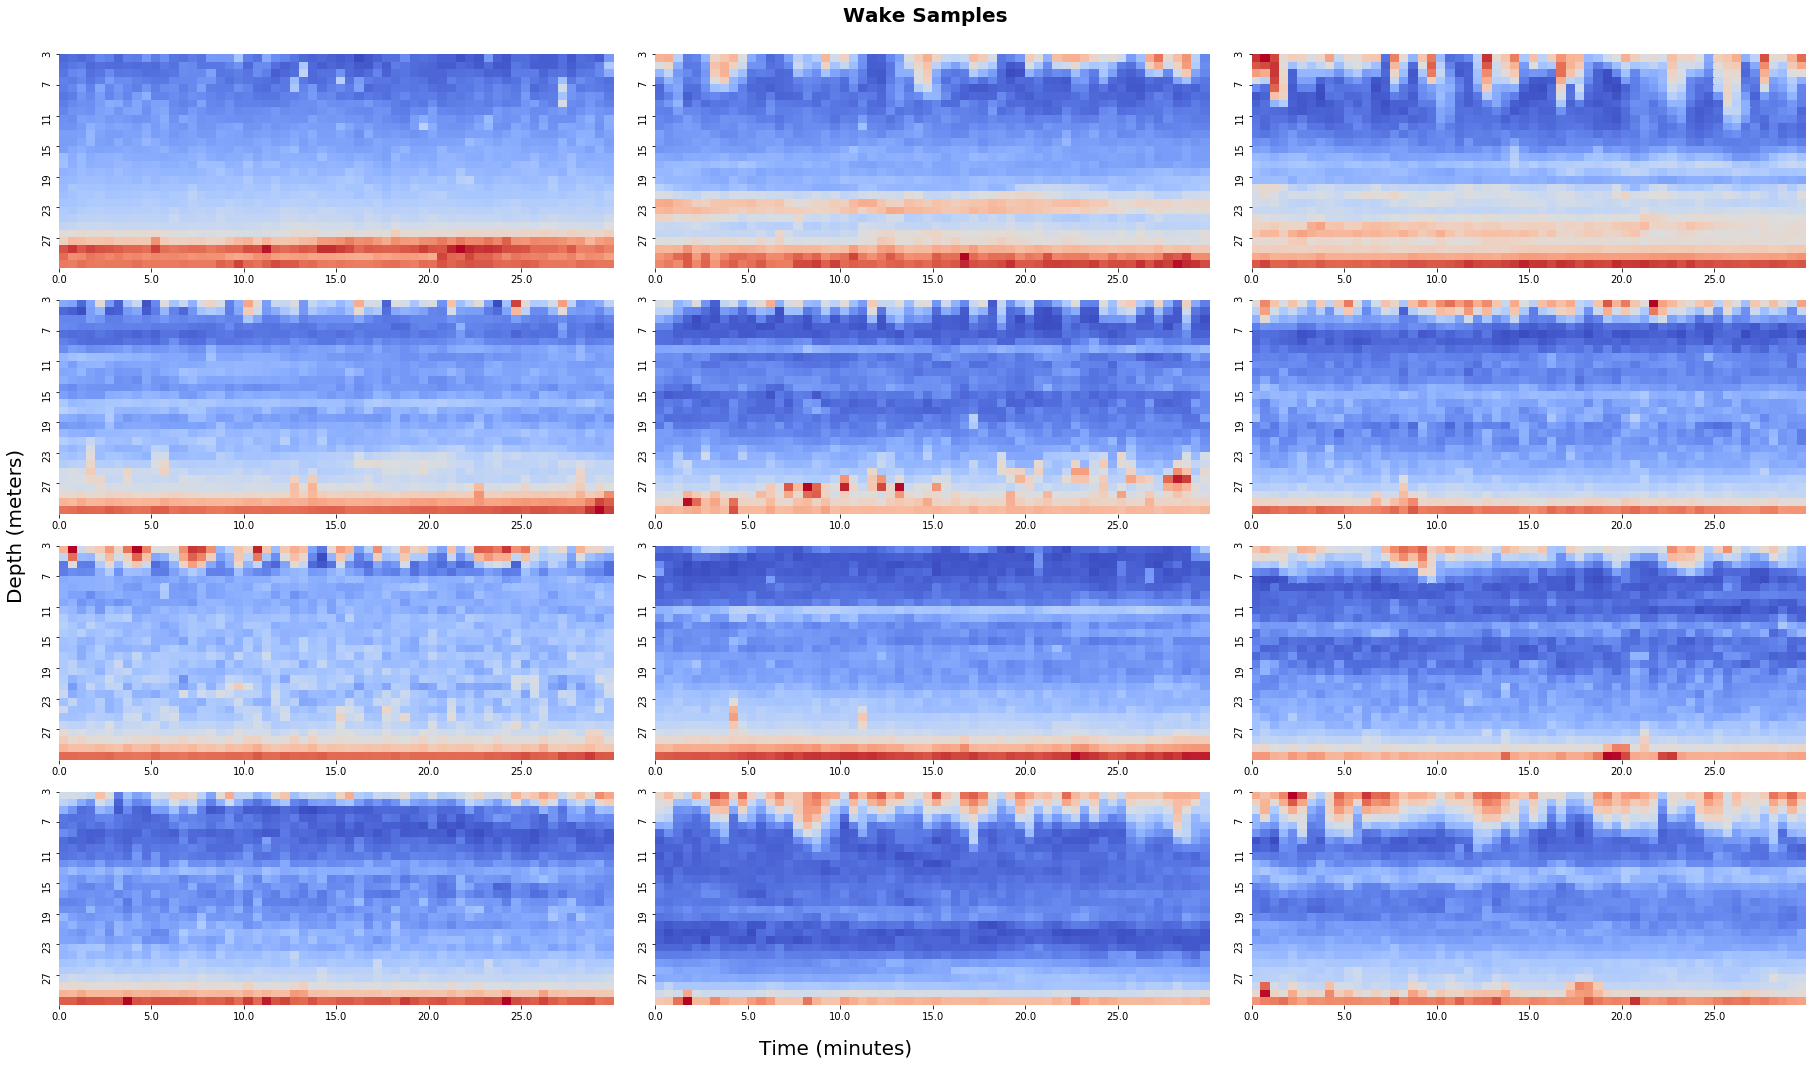

In [22]:
wp.make_12_heatmaps(clean_neg_frames[-12:,3, :-1, :])

In [31]:
clean_neg_frames[1, 3, :]

array([[1.72283426e-01, 1.31968498e-01, 1.25039339e-01, ...,
        1.64724410e-01, 1.52440920e-01, 1.68189004e-01],
       [1.71968475e-01, 1.62519649e-01, 1.92126006e-01, ...,
        1.91811055e-01, 1.71338558e-01, 1.81732252e-01],
       [2.13228330e-01, 1.77952781e-01, 1.93070874e-01, ...,
        2.14488149e-01, 1.93700776e-01, 2.03464553e-01],
       ...,
       [6.17952764e-01, 6.30866170e-01, 6.32755876e-01, ...,
        6.07874036e-01, 6.09133840e-01, 6.18897557e-01],
       [6.82519615e-01, 6.91023648e-01, 6.85984194e-01, ...,
        6.88818872e-01, 6.85984194e-01, 6.96692884e-01],
       [9.36000000e+04, 9.36300000e+04, 9.36600000e+04, ...,
        9.53100000e+04, 9.53400000e+04, 9.53700000e+04]])

## CNN autoencoder

In [32]:
model = None
model = ae.Autoencoder()
model.double()
epochs = 80
outputs = ae.train_autoencoder(model, wake_samples[:,:,:-1,:], num_epochs=epochs, batch_size = 5)

Epoch:1, Loss:0.8543
Epoch:2, Loss:0.4658
Epoch:3, Loss:0.3431
Epoch:4, Loss:0.3011
Epoch:5, Loss:0.2604
Epoch:6, Loss:0.2276
Epoch:7, Loss:0.2087
Epoch:8, Loss:0.1945
Epoch:9, Loss:0.1776
Epoch:10, Loss:0.1665
Epoch:11, Loss:0.1607
Epoch:12, Loss:0.1510
Epoch:13, Loss:0.1464
Epoch:14, Loss:0.1421
Epoch:15, Loss:0.1392
Epoch:16, Loss:0.1336
Epoch:17, Loss:0.1299
Epoch:18, Loss:0.1269
Epoch:19, Loss:0.1225
Epoch:20, Loss:0.1177
Epoch:21, Loss:0.1185
Epoch:22, Loss:0.1194
Epoch:23, Loss:0.1160
Epoch:24, Loss:0.1150
Epoch:25, Loss:0.1136
Epoch:26, Loss:0.1123
Epoch:27, Loss:0.1117
Epoch:28, Loss:0.1125
Epoch:29, Loss:0.1111
Epoch:30, Loss:0.1090
Epoch:31, Loss:0.1109
Epoch:32, Loss:0.1098
Epoch:33, Loss:0.1107
Epoch:34, Loss:0.1055
Epoch:35, Loss:0.1029
Epoch:36, Loss:0.1028
Epoch:37, Loss:0.1010
Epoch:38, Loss:0.1022
Epoch:39, Loss:0.1002
Epoch:40, Loss:0.0987
Epoch:41, Loss:0.1113
Epoch:42, Loss:0.1068
Epoch:43, Loss:0.1040
Epoch:44, Loss:0.1035
Epoch:45, Loss:0.1038
Epoch:46, Loss:0.09

In [33]:
test_reconst = ae.test_reconstruction(model, wake_samples[141,:,:-1,:])

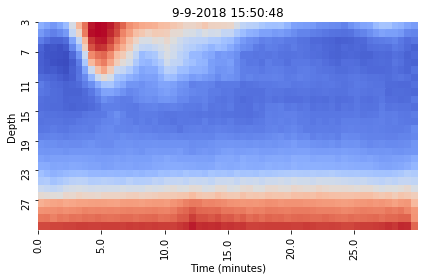

In [34]:
wp.make_heatmap(test_reconst[3], wake_samples[141,3,-1,:])

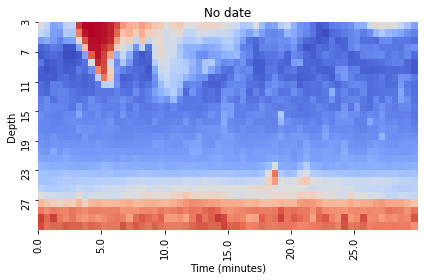

In [35]:
wp.make_heatmap(wake_samples[141,3,:-1,:], None)

## Positive samples with GMM and CNN

In [36]:
compressed_wakes = ae.compress_wakes(wake_samples, model)

In [37]:
compressed_wakes.shape

(142, 1, 64, 1, 9)

In [38]:
gmm_cnn_data = np.array([w.flatten() for w in compressed_wakes])
pca_cnn = PCA(0.999, whiten=True)
data_cnn = pca_cnn.fit_transform(gmm_cnn_data)

In [39]:
data_cnn.shape

(142, 55)

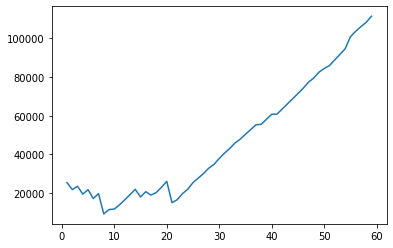

In [40]:

n_components = np.arange(1, 60)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data_cnn).aic(data_cnn) for model in models]
plt.plot(n_components, aics)
plt.show()

In [41]:
gmm_cnn = GMM(21, covariance_type='full', random_state=44)
gmm_cnn.fit(data_cnn)
cnn_pca_seeds = gmm_cnn.sample(1000) #Sampling 1000 frames for the positive data
cnn_seeds = pca_cnn.inverse_transform(cnn_pca_seeds[0])

In [42]:
decompressed_wakes = ae.decompress_wakes(cnn_seeds, model)

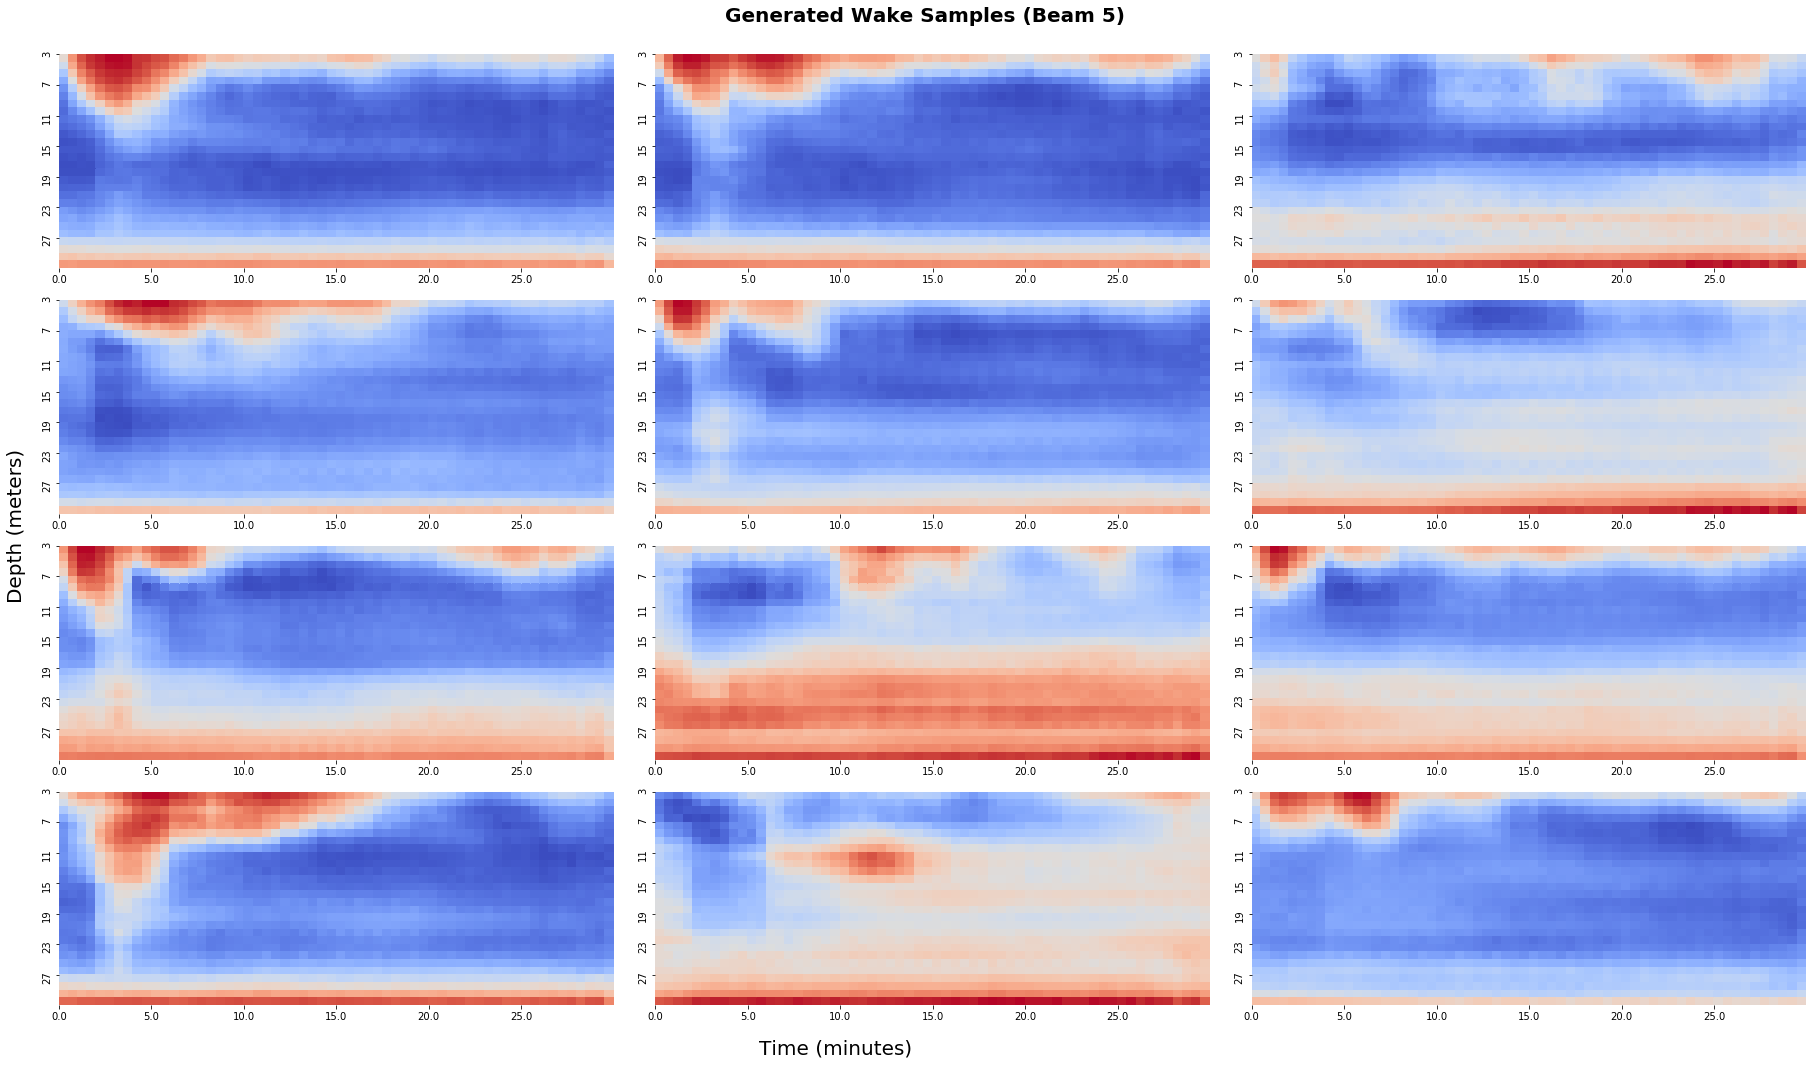

In [43]:
wp.make_12_heatmaps(decompressed_wakes[24:36,3, :, :], title =  'Generated Wake Samples (Beam 5)')

In [50]:
#np.save("Data//Wake data//generated_wakes_1000", decompressed_wakes) 

In [49]:
decompressed_wakes.min()

0.029228031686303533

## Random negative samples

In [53]:
neg_series = train_data_series
for ws in new_ws:
    neg_series = neg_series[:,:,np.where((ws-1800 >= neg_series[0,-1]) | (neg_series[0,-1]  >= ws+1800))][:,:,0,:]

In [54]:
neg_ind = neg_series.shape[2]-60

In [55]:
rand_fs = np.random.randint(neg_ind, size=3000)

In [56]:
neg_samples = []
for fs in rand_fs:
    neg_samples.append(neg_series[:,:-1, fs:fs+60])

In [57]:
neg_samples = np.array(neg_samples)

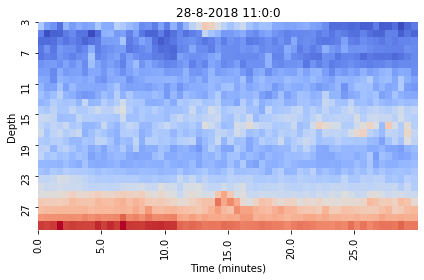

In [58]:
wp.make_heatmap(neg_samples[5,3,:-1], neg_samples[5, 3,-1])

In [65]:
#np.save('Data\Wake data\\negative_samples_3000', neg_samples) 

In [64]:
neg_samples[:,:,-1,:].min()

0.5042519569396973

## Random negative samples (day)

In [75]:
neg_dn_series = train_dn_series
for ws in new_ws:
    neg_dn_series = neg_dn_series[:,:,np.where((ws-1800 >= neg_dn_series[0,-2]) | (neg_dn_series[0,-2]  >= ws+1800))][:,:,0,:]

In [76]:
neg_dn_series.shape

(4, 30, 55346)

In [77]:
np.where(data_series[0,-1] == 1)[0].shape

(43323,)

In [78]:
np.where(neg_dn_series[0,-1] == 1)[0].shape

(30344,)

In [79]:
day_data = neg_dn_series[:,:,np.where(neg_dn_series[0,-1] == 1)[0]]

In [80]:
rand_day = np.random.randint(day_data.shape[2], size=3000)

In [81]:
neg_day_samples = []
for fs in rand_day:
    neg_day_samples.append(neg_dn_series[:,:-1, fs:fs+60])
neg_day_samples = np.array(neg_day_samples)

In [82]:
neg_day_samples.shape

(3000, 4, 29, 60)

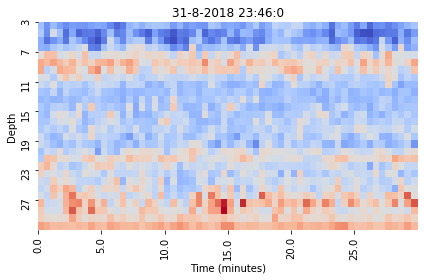

In [83]:
wp.make_heatmap(neg_day_samples[3,3,:-1], neg_day_samples[3, 3,-1])

In [93]:
neg_day_samples[:,:,:-1,:].min()

0.02740158885717392

In [94]:
np.save('Data\Wake data\\negative_samples_3000_day', neg_day_samples) 

## Beam comparison

In [65]:
blue = train_data_series[:,:-1,:].min()
flat_blue = (np.ones((28,60))*blue).flatten()

In [110]:
wasdist =[[],[],[],[]]
for w in wake_samples[:,:,:-1,:]:
    for i in range(4):
        wasdist[i].append(w_dist(w[i,:,:].flatten(), flat_blue))
wasdist_agg =[[],[],[],[]]
temp = [0,0,0,0]
for i in range(142):
    for j in range(4):
        wasdist_agg[j].append(wasdist[j][i] + temp[j])
        temp[j] += wasdist[j][i]

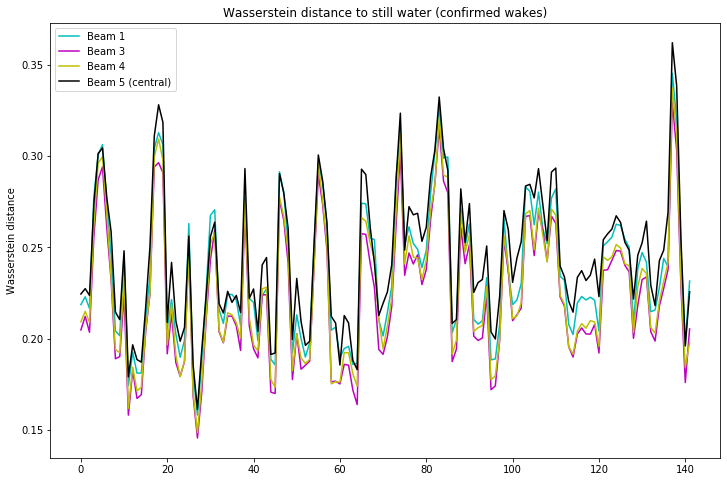

In [111]:
plt.figure(figsize=(12,8))
plt.plot(wasdist[0], 'c', label = 'Beam 1')
plt.plot(wasdist[1], 'm', label = 'Beam 3')
plt.plot(wasdist[2], 'y', label = 'Beam 4')
plt.plot(wasdist[3], 'k', label = 'Beam 5 (central)')
plt.title('Wasserstein distance to still water (confirmed wakes)')
plt.ylabel('Wasserstein distance')
plt.legend(loc = 'upper left')
plt.show()

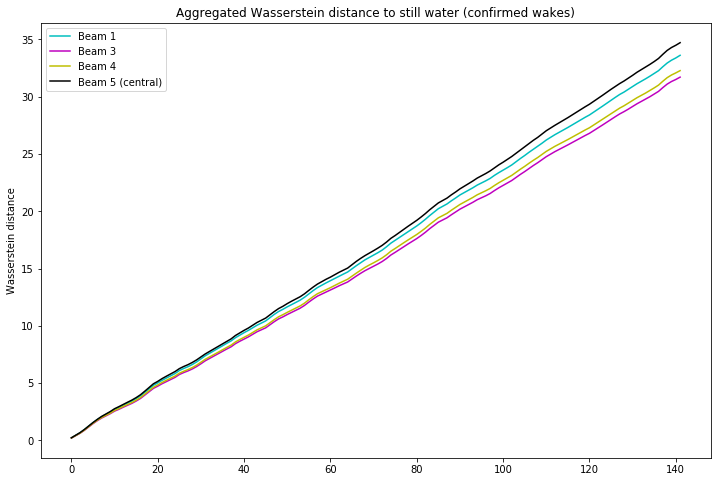

In [112]:
plt.figure(figsize=(12,8))
plt.plot(wasdist_agg[0], 'c', label = 'Beam 1')
plt.plot(wasdist_agg[1], 'm', label = 'Beam 3')
plt.plot(wasdist_agg[2], 'y', label = 'Beam 4')
plt.plot(wasdist_agg[3], 'k', label = 'Beam 5 (central)')
plt.title('Aggregated Wasserstein distance to still water (confirmed wakes)')
plt.ylabel('Wasserstein distance')
plt.legend()
plt.show()

In [323]:
wasdist_rand =[[],[],[],[]]
for w in neg_samples[:,:,:-1,:]:
    for i in range(4):
        wasdist_rand[i].append(w_dist(w[i,:,:].flatten(), flat_blue))

wasdist_rand_agg =[[],[],[],[]]
temp = [0,0,0,0]
for i in range(neg_samples.shape[0]):
    for j in range(4):
        wasdist_rand_agg[j].append(wasdist_rand[j][i] + temp[j])
        temp[j] += wasdist_rand[j][i]

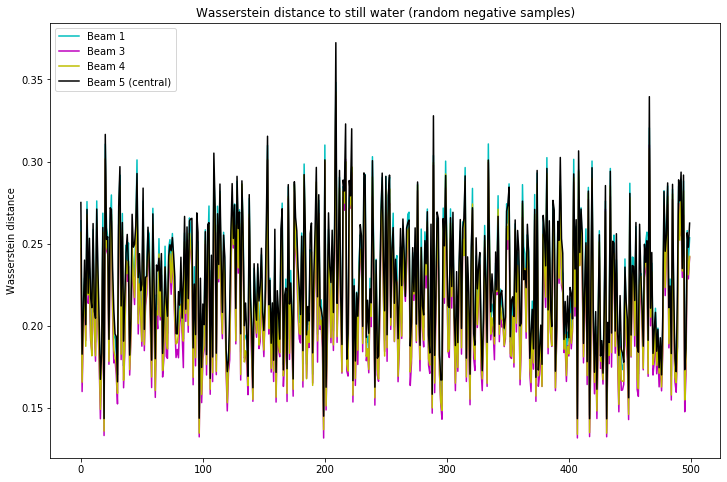

In [324]:
plt.figure(figsize=(12,8))
plt.plot(wasdist_rand[0], 'c', label = 'Beam 1')
plt.plot(wasdist_rand[1], 'm', label = 'Beam 3')
plt.plot(wasdist_rand[2], 'y', label = 'Beam 4')
plt.plot(wasdist_rand[3], 'k', label = 'Beam 5 (central)')
plt.title('Wasserstein distance to still water (random negative samples)')
plt.ylabel('Wasserstein distance')
plt.legend(loc = 'upper left')
plt.show()

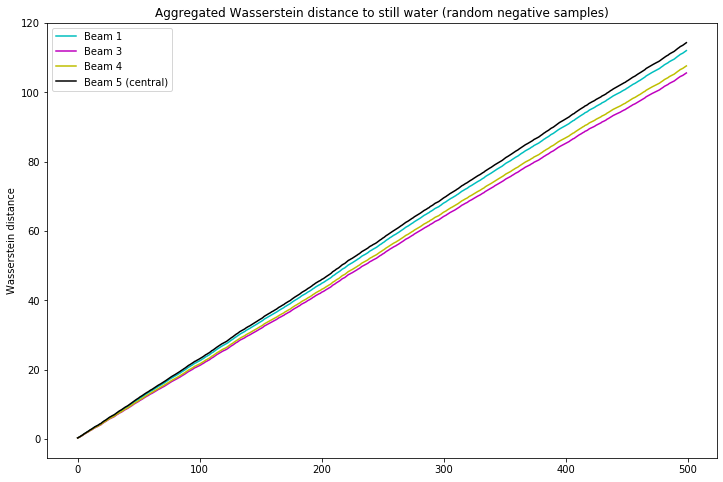

In [325]:
plt.figure(figsize=(12,8))
plt.plot(wasdist_rand_agg[0], 'c', label = 'Beam 1')
plt.plot(wasdist_rand_agg[1], 'm', label = 'Beam 3')
plt.plot(wasdist_rand_agg[2], 'y', label = 'Beam 4')
plt.plot(wasdist_rand_agg[3], 'k', label = 'Beam 5 (central)')
plt.title('Aggregated Wasserstein distance to still water (random negative samples)')
plt.ylabel('Wasserstein distance')
plt.legend()
plt.show()

## Wasserstein distances

In [103]:
w_total = 0
for w1 in wake_samples[:,:,:-1,:]:
    for w2 in decompressed_wakes:
        for i in range(4):
            w_total+=w_dist(w1[i,:-1].flatten(), w2[i,:-1].flatten())
print('Average wasserstein distance generated vs. real wakes:', w_total/(4*wake_samples.shape[0]*decompressed_wakes.shape[0]))

Average wasserstein distance generated vs. real wakes: 0.05264261361529561


In [101]:
w_total = 0
for w1 in neg_samples[:,:,:-1,:]:
    for w2 in decompressed_wakes:
        for i in range(4):
            w_total+=w_dist(w1[i,:-1].flatten(), w2[i,:-1].flatten())
print('Average wasserstein distance generated vs. random frames:', w_total/(4*neg_samples.shape[0]*decompressed_wakes.shape[0]))

Average wasserstein distance generated vs. random frames: 0.054311832316778816


In [102]:
w_total = 0
for w1 in wake_samples[:,:,:-1,:]:
    for w2 in neg_samples[:,:,:-1,:]:
        for i in range(4):
            w_total+=w_dist(w1[i,:-1].flatten(), w2[i,:-1].flatten())
print('Average wasserstein distance random frames vs. real wakes:', w_total/(4*wake_samples.shape[0]*neg_samples.shape[0]))

Average wasserstein distance random frames vs. real wakes: 0.05442177151385353
